- https://www.kaggle.com/raddar/paris-madness/notebook

In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections
import shap

# Load the data

In [2]:
# Environment Kaggle or Local?
ENVIRONMENT = 'local'

# Competition year 2019? or 2020?
COMPETITION_YEAR = 2020

In [3]:
if ENVIRONMENT == 'local' and COMPETITION_YEAR == 2019:
    tourney_detail = pd.read_csv('input/MDataFiles_Stage1/NCAATourneyDetailedResults.csv')
    tourney_detail_reload = pd.read_csv('input/MDataFiles_Stage1/NCAATourneyDetailedResults.csv')
    seeds = pd.read_csv('input/MDataFiles_Stage1/NCAATourneySeeds.csv')
    regular_detail = pd.read_csv('input/MDataFiles_Stage1/Prelim2019_RegularSeasonDetailedResults.csv')
    regular_detail_reload = pd.read_csv('input/MDataFiles_Stage1/Prelim2019_RegularSeasonDetailedResults.csv')
    submission = pd.read_csv('input/SampleSubmissionStage2.csv')
    conference_tourney_games = pd.read_csv('input/MDataFiles_Stage1/Prelim2019_ConferenceTourneyGames.csv')
    team_conferences = pd.read_csv('input/MDataFiles_Stage1/TeamConferences.csv')
    
elif ENVIRONMENT == 'local' and COMPETITION_YEAR == 2020:
    tourney_detail = pd.read_csv('input/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
    tourney_detail_reload = pd.read_csv('input/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
    seeds = pd.read_csv('input/MDataFiles_Stage1/MNCAATourneySeeds.csv')
    regular_detail = pd.read_csv('input/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
    regular_detail_reload = pd.read_csv('input/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
    submission = pd.read_csv('input/MSampleSubmissionStage1_2020.csv')
    conference_tourney_games = pd.read_csv('input/MDataFiles_Stage1/MConferenceTourneyGames.csv')
    team_conferences = pd.read_csv('input/MDataFiles_Stage1/MTeamConferences.csv')
    
elif ENVIRONMENT == 'kaggle' and COMPETITION_YEAR == 2019:
    tourney_detail = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/Stage2DataFiles/NCAATourneyDetailedResults.csv')
    tourney_detail_reload = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/Stage2DataFiles/NCAATourneyDetailedResults.csv')
    seeds = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/Stage2DataFiles/NCAATourneySeeds.csv')
    regular_detail = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/Prelim2019_RegularSeasonDetailedResults.csv')
    regular_detail_reload = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/Prelim2019_RegularSeasonDetailedResults.csv')
    submission = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/SampleSubmissionStage2.csv')
    conference_tourney_games = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/Prelim2019_ConferenceTourneyGames.csv')
    team_conferences = pd.read_csv('/kaggle/input/mens-machine-learning-competition-2019/TeamConferences.csv')
    

In [4]:
# Check if all columns are the same between regular_detail and tourney_detail
all(regular_detail.columns == tourney_detail.columns)

True

# Data Preparation

In [5]:
regular_detail.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [6]:
# Swap the features of winning team and losing team
regular_detail_swap = regular_detail[[
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

In [7]:
# Change winning location: "Home" to "Away", "Away" to "Home"
regular_detail_swap.loc[regular_detail['WLoc'] == 'H', 'WLoc'] = 'A'
regular_detail_swap.loc[regular_detail['WLoc'] == 'A', 'WLoc'] = 'H'

# Change "WLoc" to "location"
regular_detail.columns.values[6] = 'location'
regular_detail_swap.columns.values[6] = 'location'

In [8]:
# Change letter 'W' to 'T1_' and 'L' to 'T2_'
regular_detail.columns = [column.replace('W','T1_').replace('L','T2_') for column in regular_detail.columns]

# Change letter 'L' to 'T1_' and 'W' to 'T2_'
regular_detail_swap.columns = [column.replace('L','T1_').replace('W','T2_') for column in regular_detail.columns]

In [9]:
regular_detail.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [10]:
regular_detail_swap.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1328,62,1104,68,N,0,22,53,...,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,...,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,...,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,...,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,...,14,11,13,17,22,12,14,4,4,20


In [11]:
# Concat regular_detail and regular_detail_swap together
regular_data = pd.concat([regular_detail, regular_detail_swap]).sort_index().reset_index(drop = True)

### Apply function to prepare data

In [12]:
def prepare_data(df):
    # Swap winnig team's columns and losing team's columns
    df_swap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    df_swap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    df_swap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    df_swap.columns.values[6] = 'location'    
      
    df.columns = [column.replace('W','T1_').replace('L','T2_') for column in df.columns]
    df_swap.columns = [column.replace('L','T1_').replace('W','T2_') for column in df_swap.columns]

    df_concat = pd.concat([df, df_swap]).reset_index(drop=True)
    
    # -1, 0, 1 encoding
    df_concat.loc[df_concat.location=='N','location'] = '0'
    df_concat.loc[df_concat.location=='H','location'] = '1'
    df_concat.loc[df_concat.location=='A','location'] = '-1'
    df_concat.location = df_concat.location.astype(int)
    
    df_concat['PointDiff'] = df_concat['T1_Score'] - df_concat['T2_Score']
    
    return df_concat

In [13]:
# Reload data ot put into the function
regular_data = prepare_data(regular_detail_reload)
tourney_data = prepare_data(tourney_detail_reload)

In [14]:
regular_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,10,1104,68,1328,62,0,0,27,58,...,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,0,0,26,62,...,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,0,0,24,58,...,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,0,0,18,38,...,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,0,0,30,61,...,17,27,21,15,12,10,7,1,14,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175003,2019,132,1222,57,1153,69,0,0,19,62,...,19,25,12,27,6,11,2,3,16,-12
175004,2019,132,1426,64,1209,73,0,0,23,64,...,25,34,5,31,8,10,4,5,18,-9
175005,2019,132,1276,60,1277,65,0,0,21,51,...,12,16,11,27,14,9,2,6,10,-5
175006,2019,132,1382,53,1387,55,0,0,19,56,...,7,15,15,25,13,6,6,8,11,-2


In [15]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,...,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,...,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,...,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,...,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,...,15,20,10,26,16,14,5,8,19,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,146,1246,71,1120,77,0,1,27,61,...,18,24,12,25,8,9,10,7,21,-6
2226,2019,146,1181,67,1277,68,0,0,26,57,...,2,6,11,20,18,7,11,3,11,-1
2227,2019,152,1277,51,1403,61,0,0,15,47,...,8,13,3,27,8,7,4,4,18,-10
2228,2019,152,1120,62,1438,63,0,0,21,55,...,6,12,5,26,15,8,1,9,12,-1


# Feature engineering

In [16]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

In [17]:
boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [18]:
season_team_boxscore_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_team_boxscore_statistics.head()

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,...,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
,,,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,...,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,...,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,...,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,...,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,...,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [19]:
season_team_boxscore_statistics.columns = [''.join(col).strip() for col in season_team_boxscore_statistics.columns.values]
season_team_boxscore_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,...,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,...,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,...,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,...,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,...,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,...,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [20]:
season_T1_boxscore_stat = season_team_boxscore_statistics.copy()
season_T2_boxscore_stat = season_team_boxscore_statistics.copy()

season_T1_boxscore_stat.columns = ["T1_" + column.replace("T1_","").replace("T2_","opponent_") for column in season_T1_boxscore_stat.columns]
season_T2_boxscore_stat.columns = ["T2_" + column.replace("T1_","").replace("T2_","opponent_") for column in season_T2_boxscore_stat.columns]
season_T1_boxscore_stat.columns.values[0] = "Season"
season_T2_boxscore_stat.columns.values[0] = "Season"

In [21]:
season_T1_boxscore_stat.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,...,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,...,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,...,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,...,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,...,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,...,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [22]:
season_T2_boxscore_stat.head()

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,...,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,...,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,...,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,...,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,...,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,...,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [23]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]

In [24]:
tourney_data = pd.merge(tourney_data, season_T1_boxscore_stat, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_T2_boxscore_stat, on = ['Season', 'T2_TeamID'], how = 'left')

In [25]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000


In [26]:
# Extract the last 14days statistics (132 - 14 = 118)
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
# Winning rate of each team according to the season
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [27]:
last14days_stats_T1

,Season,T1_TeamID,T1_win_ratio_14d
0,2003,1102,0.333333
1,2003,1103,0.333333
2,2003,1104,0.333333
3,2003,1105,0.000000
4,2003,1106,0.500000
...,...,...,...
5611,2019,1462,0.500000
5612,2019,1463,0.750000
5613,2019,1464,0.000000
5614,2019,1465,0.500000


In [28]:
last14days_stats_T2

,Season,T2_TeamID,T2_win_ratio_14d
0,2003,1102,0.333333
1,2003,1103,0.333333
2,2003,1104,0.333333
3,2003,1105,0.000000
4,2003,1106,0.500000
...,...,...,...
5611,2019,1462,0.500000
5612,2019,1463,0.750000
5613,2019,1464,0.000000
5614,2019,1465,0.500000


In [29]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [30]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,146,1246,71,1120,77,26.606061,55.606061,6.030303,16.575758,...,8.323529,23.382353,10.764706,12.029412,17.588235,5.911765,3.676471,10.294118,0.750000,1.000000
2226,2019,146,1181,67,1277,68,30.500000,63.911765,7.264706,24.058824,...,7.264706,22.852941,11.029412,12.382353,10.264706,6.411765,2.941176,13.294118,0.800000,1.000000
2227,2019,152,1277,51,1403,61,27.764706,57.176471,8.294118,21.617647,...,6.343750,21.062500,10.125000,9.531250,15.656250,6.437500,2.468750,13.812500,1.000000,0.666667
2228,2019,152,1120,62,1438,63,27.029412,60.441176,11.411765,29.970588,...,5.812500,21.406250,9.000000,8.718750,11.000000,5.187500,2.750000,16.781250,1.000000,0.750000


In [31]:
seeds['Seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head()

,Season,Seed,TeamID
0,1985,1,1207
1,1985,2,1210
2,1985,3,1228
3,1985,4,1260
4,1985,5,1374


In [32]:
seeds_T1 = seeds[['Season','TeamID','Seed']].copy()
seeds_T2 = seeds[['Season','TeamID','Seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [33]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [34]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333,16,16,0
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000,1,16,-15
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000,10,7,3
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000,11,6,5
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000,8,9,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,146,1246,71,1120,77,26.606061,55.606061,6.030303,16.575758,...,12.029412,17.588235,5.911765,3.676471,10.294118,0.750000,1.000000,2,5,-3
2226,2019,146,1181,67,1277,68,30.500000,63.911765,7.264706,24.058824,...,12.382353,10.264706,6.411765,2.941176,13.294118,0.800000,1.000000,1,2,-1
2227,2019,152,1277,51,1403,61,27.764706,57.176471,8.294118,21.617647,...,9.531250,15.656250,6.437500,2.468750,13.812500,1.000000,0.666667,2,3,-1
2228,2019,152,1120,62,1438,63,27.029412,60.441176,11.411765,29.970588,...,8.718750,11.000000,5.187500,2.750000,16.781250,1.000000,0.750000,5,1,4


In [35]:
# Add Score Sum Feature
season_team_score_sum = regular_data.groupby(['Season', 'T1_TeamID'])['T1_Score'].sum().reset_index()
season_team_score_sum.rename(columns={'T1_TeamID': 'TeamID', 'T1_Score': 'Score_Sum'}, inplace=True)
season_team_score_sum

,Season,TeamID,Score_Sum
0,2003,1102,1603
1,2003,1103,2127
2,2003,1104,1940
3,2003,1105,1866
4,2003,1106,1781
...,...,...,...
5829,2019,1462,2372
5830,2019,1463,2265
5831,2019,1464,2205
5832,2019,1465,1962


In [36]:
tourney_data = pd.merge(tourney_data, season_team_score_sum,
                        how='left',
                        left_on=['Season', 'T1_TeamID'],
                        right_on=['Season', 'TeamID'])
tourney_data.rename(columns={'Score_Sum': 'T1_Score_Sum'}, inplace=True)
tourney_data.drop(['TeamID'], axis=1, inplace=True)
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_Score_Sum
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333,16,16,0,2065
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000,1,16,-15,2386
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000,10,7,3,2203
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000,11,6,5,2301
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000,8,9,-1,2160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,146,1246,71,1120,77,26.606061,55.606061,6.030303,16.575758,...,17.588235,5.911765,3.676471,10.294118,0.750000,1.000000,2,5,-3,2532
2226,2019,146,1181,67,1277,68,30.500000,63.911765,7.264706,24.058824,...,10.264706,6.411765,2.941176,13.294118,0.800000,1.000000,1,2,-1,2839
2227,2019,152,1277,51,1403,61,27.764706,57.176471,8.294118,21.617647,...,15.656250,6.437500,2.468750,13.812500,1.000000,0.666667,2,3,-1,2680
2228,2019,152,1120,62,1438,63,27.029412,60.441176,11.411765,29.970588,...,11.000000,5.187500,2.750000,16.781250,1.000000,0.750000,5,1,4,2682


In [37]:
tourney_data = pd.merge(tourney_data, season_team_score_sum,
                        how='left',
                        left_on=['Season', 'T2_TeamID'],
                        right_on=['Season', 'TeamID'])
tourney_data.rename(columns={'Score_Sum': 'T2_Score_Sum'}, inplace=True)
tourney_data.drop(['TeamID'], axis=1, inplace=True)
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_Score_Sum,T2_Score_Sum
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,8.000000,2.600000,1.966667,1.000000,0.833333,16,16,0,2065,2184
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,7.103448,3.655172,4.655172,0.666667,1.000000,1,16,-15,2386,1966
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,7.275862,3.172414,8.689655,0.666667,0.750000,10,7,3,2203,2161
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,6.333333,2.575758,14.909091,1.000000,1.000000,11,6,5,2301,2615
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,7.433333,2.833333,4.400000,0.333333,0.600000,8,9,-1,2160,2172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,146,1246,71,1120,77,26.606061,55.606061,6.030303,16.575758,...,5.911765,3.676471,10.294118,0.750000,1.000000,2,5,-3,2532,2682
2226,2019,146,1181,67,1277,68,30.500000,63.911765,7.264706,24.058824,...,6.411765,2.941176,13.294118,0.800000,1.000000,1,2,-1,2839,2680
2227,2019,152,1277,51,1403,61,27.764706,57.176471,8.294118,21.617647,...,6.437500,2.468750,13.812500,1.000000,0.666667,2,3,-1,2680,2339
2228,2019,152,1120,62,1438,63,27.029412,60.441176,11.411765,29.970588,...,5.187500,2.750000,16.781250,1.000000,0.750000,5,1,4,2682,2299


In [38]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
regular_season_effects

,Season,T1_TeamID,T2_TeamID,PointDiff,win
0,2003,1104,1328,6,1
1,2003,1272,1393,7,1
2,2003,1266,1437,12,1
3,2003,1296,1457,6,1
4,2003,1400,1208,6,1
...,...,...,...,...,...
175003,2019,1222,1153,-12,0
175004,2019,1426,1209,-9,0
175005,2019,1276,1277,-5,0
175006,2019,1382,1387,-2,0


In [39]:
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
march_madness

,Season,T1_TeamID,T2_TeamID
0,1985,1207,1207
1,1985,1207,1210
2,1985,1207,1228
3,1985,1207,1260
4,1985,1207,1374
...,...,...,...
149397,2019,1205,1332
149398,2019,1205,1414
149399,2019,1205,1330
149400,2019,1205,1159


In [40]:
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects

,Season,T1_TeamID,T2_TeamID,PointDiff,win
0,2003,1104,1328,6,1
1,2003,1272,1393,7,1
2,2003,1323,1237,44,1
3,2003,1242,1221,24,1
4,2003,1390,1462,1,1
...,...,...,...,...,...
9909,2019,1280,1397,-17,0
9910,2019,1280,1397,-7,0
9911,2019,1397,1120,-4,0
9912,2019,1397,1120,-20,0


In [41]:
# Function to add quality feature
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [42]:
glm_quality = pd.concat([
                        team_quality(2003),
                        team_quality(2004),
                        team_quality(2005),
                        team_quality(2006),
                        team_quality(2007),
                        team_quality(2008),
                        team_quality(2009),
                        team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                        team_quality(2019)]).reset_index(drop=True)

C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:889: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:889: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\pan

In [43]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [44]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [45]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_Score_Sum,T2_Score_Sum,T1_quality,T2_quality
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,1.966667,1.000000,0.833333,16,16,0,2065,2184,1.344286e-49,1.568239e-18
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,4.655172,0.666667,1.000000,1,16,-15,2386,1966,4.934326e+00,1.656674e-18
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,8.689655,0.666667,0.750000,10,7,3,2203,2161,3.521347e-01,1.194127e+00
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,14.909091,1.000000,1.000000,11,6,5,2301,2615,NaN,2.604195e+00
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,4.400000,0.333333,0.600000,8,9,-1,2160,2172,9.548861e-01,9.477385e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,146,1246,71,1120,77,26.606061,55.606061,6.030303,16.575758,...,10.294118,0.750000,1.000000,2,5,-3,2532,2682,2.071424e+15,5.055346e+14
2226,2019,146,1181,67,1277,68,30.500000,63.911765,7.264706,24.058824,...,13.294118,0.800000,1.000000,1,2,-1,2839,2680,4.397451e+15,3.972418e+15
2227,2019,152,1277,51,1403,61,27.764706,57.176471,8.294118,21.617647,...,13.812500,1.000000,0.666667,2,3,-1,2680,2339,3.972418e+15,1.234389e+15
2228,2019,152,1120,62,1438,63,27.029412,60.441176,11.411765,29.970588,...,16.781250,1.000000,0.750000,5,1,4,2682,2299,5.055346e+14,5.850864e+15


In [46]:
team_conferences

,Season,TeamID,ConfAbbrev
0,1985,1102,wac
1,1985,1103,ovc
2,1985,1104,sec
3,1985,1106,swac
4,1985,1108,swac
...,...,...,...
11589,2020,1463,ivy
11590,2020,1464,horizon
11591,2020,1465,wac
11592,2020,1466,a_sun


In [47]:
# Add Major Conferences (1 if a team is in major conference, otherwise 0)
'''
Six Major Conferences
American Athletic Conference: aac
Big East Conference: big_east
Conference USA: cusa
Mid-American Conference: mac
Mountain West Conference: mwc
Sun Belt Conference: sun_belt
'''
tourney_data = pd.merge(tourney_data, team_conferences, 
         left_on=['Season', 'T1_TeamID'],
         right_on=['Season', 'TeamID'],
         how='left')
tourney_data.drop('TeamID', axis=1, inplace=True)
tourney_data.rename(columns={'ConfAbbrev': 'T1_conference'}, inplace=True)

tourney_data = pd.merge(tourney_data, team_conferences, 
         left_on=['Season', 'T2_TeamID'],
         right_on=['Season', 'TeamID'],
         how='left')
tourney_data.drop('TeamID', axis=1, inplace=True)
tourney_data.rename(columns={'ConfAbbrev': 'T2_conference'}, inplace=True)

tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff,T1_Score_Sum,T2_Score_Sum,T1_quality,T2_quality,T1_conference,T2_conference
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,0.833333,16,16,0,2065,2184,1.344286e-49,1.568239e-18,big_south,swac
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,1.000000,1,16,-15,2386,1966,4.934326e+00,1.656674e-18,pac_ten,aec
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,0.750000,10,7,3,2203,2161,3.521347e-01,1.194127e+00,pac_ten,cusa
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,1.000000,11,6,5,2301,2615,NaN,2.604195e+00,mac,mvc
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,0.600000,8,9,-1,2160,2172,9.548861e-01,9.477385e-02,pac_ten,acc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,146,1246,71,1120,77,26.606061,55.606061,6.030303,16.575758,...,1.000000,2,5,-3,2532,2682,2.071424e+15,5.055346e+14,sec,sec
2226,2019,146,1181,67,1277,68,30.500000,63.911765,7.264706,24.058824,...,1.000000,1,2,-1,2839,2680,4.397451e+15,3.972418e+15,acc,big_ten
2227,2019,152,1277,51,1403,61,27.764706,57.176471,8.294118,21.617647,...,0.666667,2,3,-1,2680,2339,3.972418e+15,1.234389e+15,big_ten,big_twelve
2228,2019,152,1120,62,1438,63,27.029412,60.441176,11.411765,29.970588,...,0.750000,5,1,4,2682,2299,5.055346e+14,5.850864e+15,sec,acc


In [48]:
major_conferences = ['aac', 'big_east', 'cusa', 'mac', 'mwc', 'sun_belt']
def is_major(conference_name):
    if conference_name in major_conferences:
        return 1
    else:
        return 0

tourney_data['T1_major_conf'] = tourney_data['T1_conference'].apply(is_major)
tourney_data['T2_major_conf'] = tourney_data['T2_conference'].apply(is_major)

In [49]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_seed,Seed_diff,T1_Score_Sum,T2_Score_Sum,T1_quality,T2_quality,T1_conference,T2_conference,T1_major_conf,T2_major_conf
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,16,0,2065,2184,1.344286e-49,1.568239e-18,big_south,swac,0,0
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,16,-15,2386,1966,4.934326e+00,1.656674e-18,pac_ten,aec,0,0
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,7,3,2203,2161,3.521347e-01,1.194127e+00,pac_ten,cusa,0,1
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,6,5,2301,2615,NaN,2.604195e+00,mac,mvc,1,0
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,9,-1,2160,2172,9.548861e-01,9.477385e-02,pac_ten,acc,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,146,1246,71,1120,77,26.606061,55.606061,6.030303,16.575758,...,5,-3,2532,2682,2.071424e+15,5.055346e+14,sec,sec,0,0
2226,2019,146,1181,67,1277,68,30.500000,63.911765,7.264706,24.058824,...,2,-1,2839,2680,4.397451e+15,3.972418e+15,acc,big_ten,0,0
2227,2019,152,1277,51,1403,61,27.764706,57.176471,8.294118,21.617647,...,3,-1,2680,2339,3.972418e+15,1.234389e+15,big_ten,big_twelve,0,0
2228,2019,152,1120,62,1438,63,27.029412,60.441176,11.411765,29.970588,...,1,4,2682,2299,5.055346e+14,5.850864e+15,sec,acc,0,0


# Modeling

In [50]:
# The most important 9 features
features = ['T2_seed', 'T1_seed', 'Seed_diff', 'T2_PointDiffmean',
            'T1_PointDiffmean', 'T2_Score_Sum', 'T1_Score_Sum',        
            'T1_opponent_FGAmean', 'T1_major_conf', 'T2_major_conf']


'''features = ['T1_seed', 'T2_seed', 'Seed_diff', 
            'T1_PointDiffmean', 'T2_PointDiffmean',
            'T1_Score_Sum', 'T2_Score_Sum', 
            'T1_quality', 'T2_quality',
            'T1_FGMmean', 'T2_FGMmean',
           'T1_win_ratio_14d', 'T2_win_ratio_14d']'''


'''features = ['T1_seed', 'T2_seed', 'Seed_diff', 'T1_PointDiffmean',
       'T2_PointDiffmean', 'T2_Score_Sum', 'T1_opponent_FGAmean',
       'T1_Score_Sum', 'T2_opponent_FGAmean', 'T2_FGMmean', 'T1_FGMmean',
       'T1_win_ratio_14d']'''

len(features)

10

In [51]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

## XGBoost

In [52]:
X = tourney_data[features].values
y = tourney_data['T1_Score'] - tourney_data['T2_Score']

xgb_dtrain = xgb.DMatrix(X, label = y)

C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [53]:
xgb_param = {} 
#param['objective'] = 'reg:linear'
xgb_param['eval_metric'] =  'logloss'
xgb_param['booster'] = 'gbtree'
xgb_param['eta'] = 0.05 #change to ~0.02 for final run
xgb_param['subsample'] = 0.35
xgb_param['colsample_bytree'] = 0.7
xgb_param['num_parallel_tree'] = 10 #recommend 10
xgb_param['min_child_weight'] = 40
xgb_param['gamma'] = 10
xgb_param['max_depth'] =  3
xgb_param['silent'] = 1

print(xgb_param)

{'eval_metric': 'logloss', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 10, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [54]:
xgb_cv = []
repeat_cv = 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = xgb_param,
          dtrain = xgb_dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-logloss:-121.948+3.6152	test-logloss:-119.223+9.16609
[50]	train-logloss:-237.127+5.64499	test-logloss:-214.277+15.1886
Fold repeater 1
[0]	train-logloss:-122.221+4.79402	test-logloss:-120.893+19.5711
[50]	train-logloss:-236.981+4.80079	test-logloss:-219.891+21.4057
Fold repeater 2
[0]	train-logloss:-123.208+6.04021	test-logloss:-122.214+8.16758
Fold repeater 3
[0]	train-logloss:-121.769+3.70644	test-logloss:-121.18+11.8793
[50]	train-logloss:-235.997+5.16884	test-logloss:-221.598+16.7315
Fold repeater 4
[0]	train-logloss:-123.605+4.19518	test-logloss:-120.319+8.75189
Fold repeater 5
[0]	train-logloss:-123.528+2.18221	test-logloss:-120.793+11.378
Fold repeater 6
[0]	train-logloss:-119.094+5.32012	test-logloss:-117.988+10.7791
[50]	train-logloss:-236.499+3.04779	test-logloss:-220.781+10.588
Fold repeater 7
[0]	train-logloss:-121.467+3.89672	test-logloss:-119.039+12.945
[50]	train-logloss:-236.681+3.70841	test-logloss:-220.34+19.7059
Fold repeater 8
[0]	train-lo

In [55]:
xgb_iteration_counts = [np.argmin(x['test-logloss-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-logloss-mean'].values) for x in xgb_cv]
xgb_iteration_counts, val_mae

([33, 30, 17, 26, 21, 23, 43, 30, 14, 33],
 [-217.65687859999997,
  -222.9398498,
  -221.75518200000002,
  -223.19816,
  -221.020511,
  -221.83321519999998,
  -222.124057,
  -222.59122939999997,
  -219.0020354,
  -221.73619979999998])

In [56]:
oof_preds = []
total_shap_df  = pd.DataFrame()

for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    
    feat_importance_df  = pd.DataFrame()
    
    for i, (train_index, val_index) in enumerate(kfold.split(X,y)):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = xgb_param,
              dtrain = dtrain_i,
              num_boost_round = xgb_iteration_counts[i],
              verbose_eval = 50
        )
        
        # Get shap values from xgb model
        shap_values = shap.TreeExplainer(model).shap_values(X[train_index])

        fold_importance_df  = pd.DataFrame()
        fold_importance_df['feature'] = tourney_data[features].columns
        fold_importance_df['shap_values'] = abs(np.array(shap_values)[:, :].mean(0))
        # fold_importance_df['feat_imp'] = model.feature_importance
        if i == 0:
            feat_importance_df = fold_importance_df
        else:
            feat_importance_df = pd.concat([feat_importance_df, fold_importance_df])

        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))
    
    feat_importance_df_shap = feat_importance_df.groupby('feature').mean().sort_values('shap_values', ascending=False).reset_index()
    total_shap_df = pd.concat([total_shap_df, feat_importance_df_shap])

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [57]:
shap_sorted_df = total_shap_df.groupby('feature').mean().sort_values('shap_values', ascending=False).reset_index()
shap_sorted_df

,feature,shap_values
0,T2_seed,0.036094
1,T1_seed,0.032425
2,Seed_diff,0.016448
3,T2_PointDiffmean,0.009668
4,T1_PointDiffmean,0.008612
5,T2_Score_Sum,0.008346
6,T1_Score_Sum,0.007809
7,T1_opponent_FGAmean,0.003155
8,T2_major_conf,0.000453
9,T1_major_conf,0.000452


[<matplotlib.lines.Line2D at 0x2cf022b2ef0>]

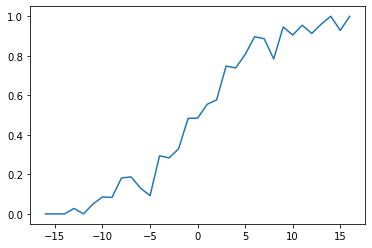

In [58]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [59]:
# Reference: https://stackoverflow.com/questions/17913330/fitting-data-using-univariatespline-in-scipy-python

spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5493208980887972
logloss of cvsplit 1: 0.5458652493863702
logloss of cvsplit 2: 0.5466905833000318
logloss of cvsplit 3: 0.5430908744256637
logloss of cvsplit 4: 0.5469020843992661
logloss of cvsplit 5: 0.5457978634067847
logloss of cvsplit 6: 0.5492275796704147
logloss of cvsplit 7: 0.5471169188688503
logloss of cvsplit 8: 0.5471311626823085
logloss of cvsplit 9: 0.5465786999095967


[<matplotlib.lines.Line2D at 0x2cf022f45c0>]

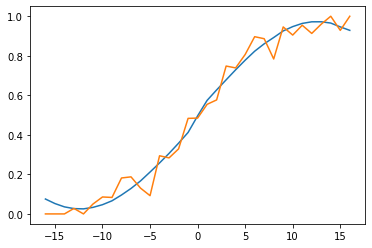

In [60]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [61]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5493217614530309
adjusted logloss of cvsplit 1: 0.5458655270246554
adjusted logloss of cvsplit 2: 0.546710001422717
adjusted logloss of cvsplit 3: 0.54306613394645
adjusted logloss of cvsplit 4: 0.5469180975762874
adjusted logloss of cvsplit 5: 0.545790106570168
adjusted logloss of cvsplit 6: 0.5492275796704147
adjusted logloss of cvsplit 7: 0.5471169425368709
adjusted logloss of cvsplit 8: 0.5471454611468665
adjusted logloss of cvsplit 9: 0.5465893900550066


In [62]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5749266512673099
adjusted logloss of cvsplit 1: 0.5715583724581376
adjusted logloss of cvsplit 2: 0.572344080004801
adjusted logloss of cvsplit 3: 0.568899636794869
adjusted logloss of cvsplit 4: 0.5726461246935999
adjusted logloss of cvsplit 5: 0.5711509721006576
adjusted logloss of cvsplit 6: 0.5745358500286321
adjusted logloss of cvsplit 7: 0.5725397278241664
adjusted logloss of cvsplit 8: 0.5727591565704138
adjusted logloss of cvsplit 9: 0.5718688651603385


In [63]:
#looking for upsets
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
).sort_values(['Season'])

#https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_seed,Seed_diff,T1_Score_Sum,T2_Score_Sum,T1_quality,T2_quality,T1_conference,T2_conference,T1_major_conf,T2_major_conf
2129,2018,137,1438,54,1420,74,25.000000,54.181818,7.363636,18.878788,...,16,-15,2229,2247,inf,0.0,acc,aec,0,0
1014,2018,137,1420,74,1438,54,25.612903,58.451613,9.838710,25.774194,...,1,15,2247,2229,0.0,inf,aec,acc,0,0


In [64]:
pd.concat(
    [tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==16)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==2)],
    tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==3)],
    tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==16)]]
).sort_values(['Season'])

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_seed,Seed_diff,T1_Score_Sum,T2_Score_Sum,T1_quality,T2_quality,T1_conference,T2_conference,T1_major_conf,T2_major_conf


In [65]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5440714411733052
adjusted logloss of cvsplit 1: 0.5405842794214352
adjusted logloss of cvsplit 2: 0.5417179118608801
adjusted logloss of cvsplit 3: 0.5385243789924986
adjusted logloss of cvsplit 4: 0.5419006143868611
adjusted logloss of cvsplit 5: 0.5410077701909717
adjusted logloss of cvsplit 6: 0.5440921110831811
adjusted logloss of cvsplit 7: 0.5417776490258204
adjusted logloss of cvsplit 8: 0.5422568868736924
adjusted logloss of cvsplit 9: 0.5411053837774097


In [66]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.5440714411733052
adjusted logloss of cvsplit 1: 0.5405842794214352
adjusted logloss of cvsplit 2: 0.5417179118608801
adjusted logloss of cvsplit 3: 0.5385243789924986
adjusted logloss of cvsplit 4: 0.5419006143868611
adjusted logloss of cvsplit 5: 0.5410077701909717
adjusted logloss of cvsplit 6: 0.5440921110831811
adjusted logloss of cvsplit 7: 0.5417776490258204
adjusted logloss of cvsplit 8: 0.5422568868736924
adjusted logloss of cvsplit 9: 0.5411053837774097


season
2003    0.517561
2004    0.505303
2005    0.521073
2006    0.562426
2007    0.439861
2008    0.496846
2009    0.476895
2010    0.562542
2011    0.596990
2012    0.579465
2013    0.621048
2014    0.600569
2015    0.527591
2016    0.587275
2017    0.511056
2018    0.602153
2019    0.489068
dtype: float64

# Submission

In [67]:
submission

,ID,Pred
0,2015_1107_1112,0.5
1,2015_1107_1116,0.5
2,2015_1107_1124,0.5
3,2015_1107_1125,0.5
4,2015_1107_1129,0.5
...,...,...
11385,2019_1449_1459,0.5
11386,2019_1449_1463,0.5
11387,2019_1458_1459,0.5
11388,2019_1458_1463,0.5


In [68]:
submission["Season"] = submission["ID"].apply(lambda x: x[:4]).astype(int)
submission["T1_TeamID"] = submission["ID"].apply(lambda x: x[5:9]).astype(int)
submission["T2_TeamID"] = submission["ID"].apply(lambda x: x[10:14]).astype(int)
submission

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2015_1107_1112,0.5,2015,1107,1112
1,2015_1107_1116,0.5,2015,1107,1116
2,2015_1107_1124,0.5,2015,1107,1124
3,2015_1107_1125,0.5,2015,1107,1125
4,2015_1107_1129,0.5,2015,1107,1129
...,...,...,...,...,...
11385,2019_1449_1459,0.5,2019,1449,1459
11386,2019_1449_1463,0.5,2019,1449,1463
11387,2019_1458_1459,0.5,2019,1458,1459
11388,2019_1458_1463,0.5,2019,1458,1463


In [69]:
submission = pd.merge(submission, season_T1_boxscore_stat, on = ['Season', 'T1_TeamID'], how='left')
submission = pd.merge(submission, season_T2_boxscore_stat, on = ['Season', 'T2_TeamID'], how='left')
submission = pd.merge(submission, seeds_T1, on = ['Season', 'T1_TeamID'], how='left')
submission = pd.merge(submission, seeds_T2, on = ['Season', 'T2_TeamID'], how='left')
submission = pd.merge(submission, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how='left')
submission = pd.merge(submission, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how='left')
submission["Seed_diff"] = submission["T1_seed"] - submission["T2_seed"]

In [70]:
# Add Score Sum Feature
submission = pd.merge(submission, season_team_score_sum,
                        how='left',
                        left_on=['Season', 'T1_TeamID'],
                        right_on=['Season', 'TeamID'])
submission.rename(columns={'Score_Sum': 'T1_Score_Sum'}, inplace=True)
submission.drop(['TeamID'], axis=1, inplace=True)

submission = pd.merge(submission, season_team_score_sum,
                        how='left',
                        left_on=['Season', 'T2_TeamID'],
                        right_on=['Season', 'TeamID'])
submission.rename(columns={'Score_Sum': 'T2_Score_Sum'}, inplace=True)
submission.drop(['TeamID'], axis=1, inplace=True)

In [71]:
submission = pd.merge(submission, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
submission = pd.merge(submission, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [72]:
submission

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,...,T2_PointDiffmean,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff,T1_Score_Sum,T2_Score_Sum,T1_quality,T2_quality
0,2015_1107_1112,0.5,2015,1107,1112,22.062500,50.156250,6.156250,17.093750,10.000000,...,17.823529,14,2,1.00,1.00,12,2096,2599,9.264272e-05,3.048010e+29
1,2015_1107_1116,0.5,2015,1107,1116,22.062500,50.156250,6.156250,17.093750,10.000000,...,7.882353,14,5,1.00,0.60,9,2096,2653,9.264272e-05,4.225904e+13
2,2015_1107_1124,0.5,2015,1107,1124,22.062500,50.156250,6.156250,17.093750,10.000000,...,8.812500,14,3,1.00,0.50,11,2096,2212,9.264272e-05,4.777225e+13
3,2015_1107_1125,0.5,2015,1107,1125,22.062500,50.156250,6.156250,17.093750,10.000000,...,3.612903,14,15,1.00,1.00,-1,2096,2287,9.264272e-05,6.254381e-05
4,2015_1107_1129,0.5,2015,1107,1129,22.062500,50.156250,6.156250,17.093750,10.000000,...,8.935484,14,11,1.00,0.75,3,2096,2166,9.264272e-05,2.483289e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2019_1449_1459,0.5,2019,1449,1459,24.558824,54.264706,7.470588,21.588235,9.470588,...,13.666667,9,7,0.60,1.00,2,2374,2436,7.357656e+13,1.434231e-03
11386,2019_1449_1463,0.5,2019,1449,1463,24.558824,54.264706,7.470588,21.588235,9.470588,...,7.178571,9,14,0.60,0.75,-5,2374,2265,7.357656e+13,9.127848e-19
11387,2019_1458_1459,0.5,2019,1458,1459,25.878788,57.121212,7.121212,19.454545,8.151515,...,13.666667,5,7,0.75,1.00,-2,2279,2436,8.284898e+14,1.434231e-03
11388,2019_1458_1463,0.5,2019,1458,1463,25.878788,57.121212,7.121212,19.454545,8.151515,...,7.178571,5,14,0.75,0.75,-9,2279,2265,8.284898e+14,9.127848e-19


In [73]:
submission = pd.merge(submission, team_conferences, 
         left_on=['Season', 'T1_TeamID'],
         right_on=['Season', 'TeamID'],
         how='left')
submission.drop('TeamID', axis=1, inplace=True)
submission.rename(columns={'ConfAbbrev': 'T1_conference'}, inplace=True)

submission = pd.merge(submission, team_conferences, 
         left_on=['Season', 'T2_TeamID'],
         right_on=['Season', 'TeamID'],
         how='left')
submission.drop('TeamID', axis=1, inplace=True)
submission.rename(columns={'ConfAbbrev': 'T2_conference'}, inplace=True)

submission['T1_major_conf'] = submission['T1_conference'].apply(is_major)
submission['T2_major_conf'] = submission['T2_conference'].apply(is_major)
submission

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,...,T2_win_ratio_14d,Seed_diff,T1_Score_Sum,T2_Score_Sum,T1_quality,T2_quality,T1_conference,T2_conference,T1_major_conf,T2_major_conf
0,2015_1107_1112,0.5,2015,1107,1112,22.062500,50.156250,6.156250,17.093750,10.000000,...,1.00,12,2096,2599,9.264272e-05,3.048010e+29,aec,pac_twelve,0,0
1,2015_1107_1116,0.5,2015,1107,1116,22.062500,50.156250,6.156250,17.093750,10.000000,...,0.60,9,2096,2653,9.264272e-05,4.225904e+13,aec,sec,0,0
2,2015_1107_1124,0.5,2015,1107,1124,22.062500,50.156250,6.156250,17.093750,10.000000,...,0.50,11,2096,2212,9.264272e-05,4.777225e+13,aec,big_twelve,0,0
3,2015_1107_1125,0.5,2015,1107,1125,22.062500,50.156250,6.156250,17.093750,10.000000,...,1.00,-1,2096,2287,9.264272e-05,6.254381e-05,aec,ovc,0,0
4,2015_1107_1129,0.5,2015,1107,1129,22.062500,50.156250,6.156250,17.093750,10.000000,...,0.75,3,2096,2166,9.264272e-05,2.483289e+12,aec,mwc,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2019_1449_1459,0.5,2019,1449,1459,24.558824,54.264706,7.470588,21.588235,9.470588,...,1.00,2,2374,2436,7.357656e+13,1.434231e-03,pac_twelve,southern,0,0
11386,2019_1449_1463,0.5,2019,1449,1463,24.558824,54.264706,7.470588,21.588235,9.470588,...,0.75,-5,2374,2265,7.357656e+13,9.127848e-19,pac_twelve,ivy,0,0
11387,2019_1458_1459,0.5,2019,1458,1459,25.878788,57.121212,7.121212,19.454545,8.151515,...,1.00,-2,2279,2436,8.284898e+14,1.434231e-03,big_ten,southern,0,0
11388,2019_1458_1463,0.5,2019,1458,1463,25.878788,57.121212,7.121212,19.454545,8.151515,...,0.75,-9,2279,2265,8.284898e+14,9.127848e-19,big_ten,ivy,0,0


### XGBoost

In [74]:
xgb_sub_models = []

for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    xgb_sub_models.append(
        xgb.train(
          params = xgb_param,
          dtrain = xgb_dtrain,
          num_boost_round = int(xgb_iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [75]:
X_submission = submission[features].values
xgb_dtest = xgb.DMatrix(X_submission)

In [76]:
xgb_sub_preds = []

# XGBoost
for i in range(repeat_cv):
    xgb_sub_preds.append(np.clip(spline_model[i](np.clip(xgb_sub_models[i].predict(xgb_dtest),-30,30)),0.025,0.975))

In [77]:
submission["Pred"] = pd.DataFrame(xgb_sub_preds).mean(axis=0)

In [78]:
submission.loc[(submission.T1_seed==1) & (submission.T2_seed==16), 'Pred'] = 1.0
submission.loc[(submission.T1_seed==2) & (submission.T2_seed==15), 'Pred'] = 1.0
submission.loc[(submission.T1_seed==3) & (submission.T2_seed==14), 'Pred'] = 1.0
submission.loc[(submission.T1_seed==16) & (submission.T2_seed==1), 'Pred'] = 0.0
submission.loc[(submission.T1_seed==15) & (submission.T2_seed==2), 'Pred'] = 0.0
submission.loc[(submission.T1_seed==14) & (submission.T2_seed==3), 'Pred'] = 0.0

if COMPETITION_YEAR == 2019:
    submission[['ID','Pred']].to_csv("submission-Men-2019.csv", index = None)
elif COMPETITION_YEAR == 2020:
    submission[['ID','Pred']].to_csv("submission-Men-2020.csv", index = None)

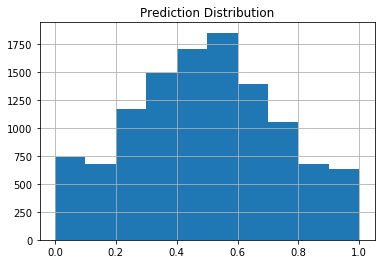

In [79]:
submission['Pred'].hist()
plt.title('Prediction Distribution');